# **Harmful Algal Bloom Occurence Rate Over Time**

Specify the directory for the notebook, make sure data is in folder as well

In [1]:
import os
os.chdir(r'C:\Users\mbido\OneDrive\Documents\ESCI 796')
print(os.getcwd())



C:\Users\mbido\OneDrive\Documents\ESCI 796


## Introduction: 
Harmful algal blooms result when excess nutrient (Phosphorous and Nitrogen) loading in water bodies combine with slow moving water and sunlight to create blue green algae which combine into Harmful Algal Blooms (HABs). There are many different types of blooms. Almost all have a negative impact on the surrounding environment, and many can be harmful to humans.


## Hypothesis:
One of the main factors in HAB formation is energy availability. In the wake of climate change, nations have taken moves to curb emissions and lower global temperatures. Are these steps readily obvious when viewing HAB occurence rate? Does HAB formation rate change throughout the state?

## Studied Site:
For this project, the state of New York will be looked at. To estimate ET, a USGS gauge and NOAA gauge near Little Falls, NY provide information on discharge and precipitation. The entirety of the state was chosen for this project due to their HAB data being readilly available online, and the more data points the stronger the conclusions that can be drawn regarding HABs. Using only a single location to try and estimate ET can result in gaps or inconclusive results. The HAB data encompasses the entire state, so direct trends will likely not be drawn. 

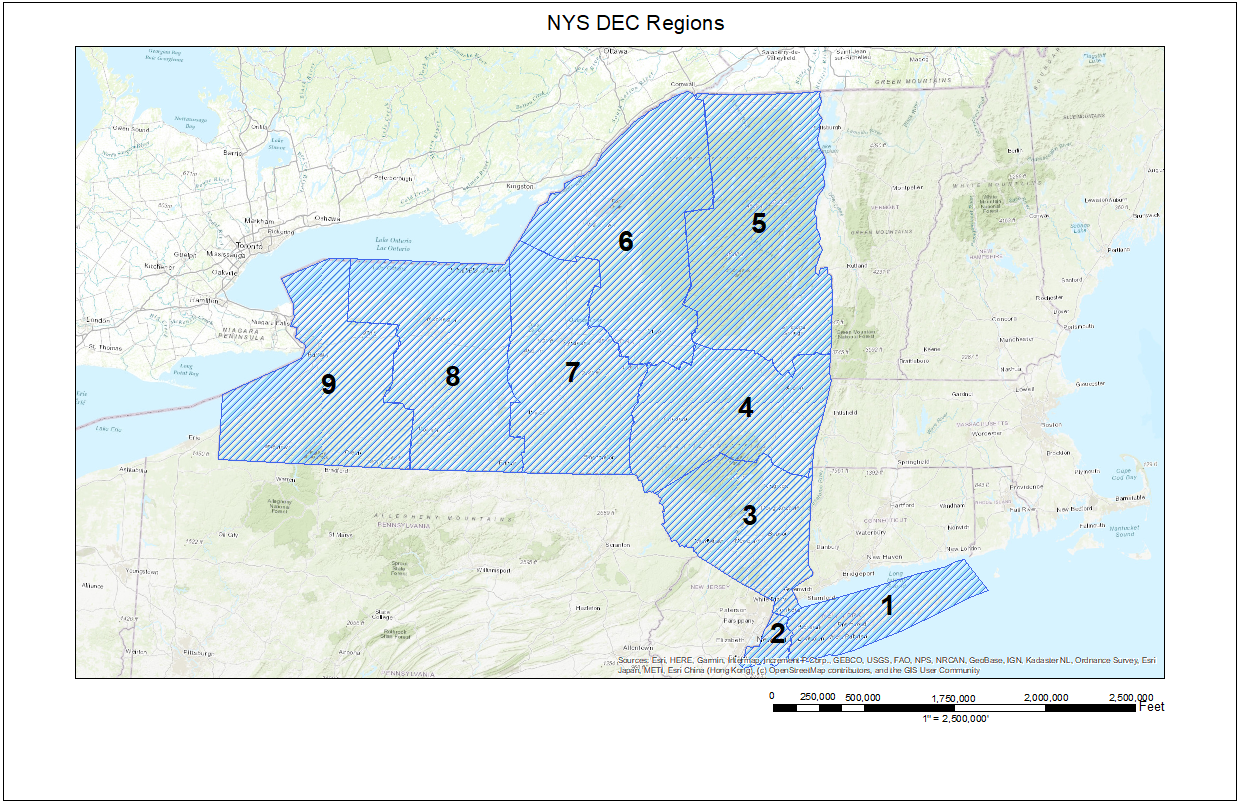

## Datasets: 
1. Harmful_Algal_Bloom_Statewide_Occurrence_Summary__2012-2018.csv - Compiled by State of New York, provides info on HAB occurences throughout the state for a certain time period. Gives info on where the HAB occurred, and how long it was on DEC watchlists for.

2. 3263069.csv - A precipitation file from the USGS. Gives snow and precipitation data for a certain time period.

3. Littlefalls.txt - A text file from NOAA. Gives discharge data for the Mohawk River near Little Falls, NY.

### Load in the data files
Identify and initially clean the data. Parameters are the duration of the study period, and square area that drains into the discharge gauge. This area should be in square miles. Convert the area into square feet. Organize the HAB data based on date, and remove unnecessary columns. Organize discharge data based on date and remove unnecessary columns. Linearly interpolate the discharge data. Trim the data the match the HAB data dates. Convert the discharge data to mm/day, from cubic feet per second based on the area parameter. Then organize precip data based on year. Any missing values to be filled with 0. If data for multi day precip exists, add it to the daily precipitation data. If not, just ude daily data. This data should also be converted to mm. Plot this inital data to visualize it.



Text(0.5, 1.0, 'Combined Precipitation')

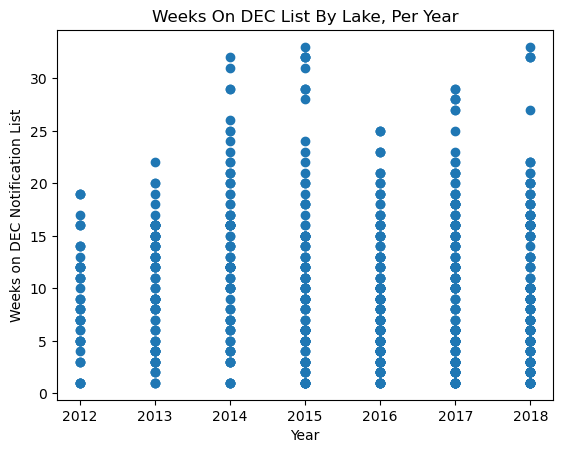

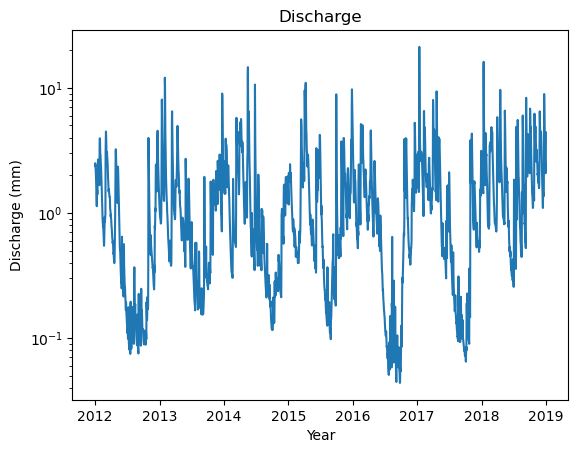

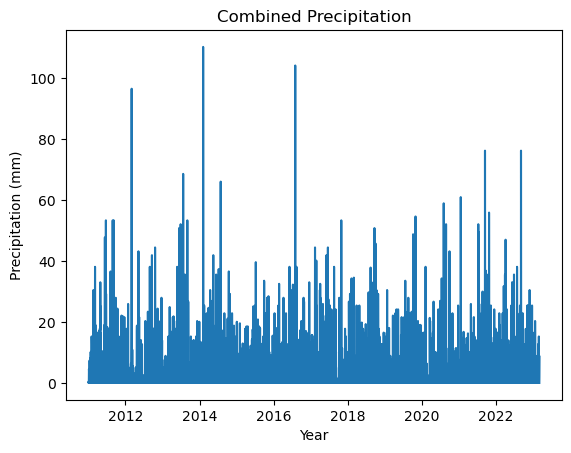

In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
duration = 7
drainage = 106

#%% Load in HAB data
# Load in the HAB data
dfhab = pd.read_csv('HAB data.csv', parse_dates=['Year'], index_col='Year')

#%% Load in discharge file
# Drainage area flowing into gauge point
area = drainage * 27878400

# Load in the file, set Date as index
dfdis = pd.read_csv('oswayo.txt', comment = "#", delimiter='\t', header = 1,
                     parse_dates=['20d'], index_col=['20d'])

# Drop unused columns
dfdis.drop(columns = {"5s", "15s", "10s"}, inplace = True)

# Fill in missing values
dfdis.interpolate(method = 'linear')

# Convert the discharge value
dfdis["Discharge_mm"] = (dfdis["14n"]/area) * 26334720   #to mm/day

# Drop old column
dfdis.drop(columns = {"14n"}, inplace = True)

#Trim to start after Jan 1st 2012
dfdis = dfdis['2012-01-01':'2019-01-01']

#%% Load in precip file
#Load in the file
dfp = pd.read_csv('3263069.csv', parse_dates=['DATE'], index_col=['DATE'])

# Fill missing values with 0
dfp = dfp.fillna(0)

# See if MDPR data exists
if 'MDPR' in dfp.columns.tolist():
     dfp['Combined'] = dfp['MDPR'] + dfp['PRCP']
else:
    dfp['Combined'] = dfp['PRCP']

#Convert to mm
dfp["Combined_Precip_mm"] = dfp["Combined"] * 25.4

#Delete old dataframes
dfp = dfp[['Combined_Precip_mm']]

#%% Initial Plots

fig1, ax1 = plt.subplots()
ax1.scatter(dfhab.index, dfhab['Number of Weeks on DEC Notification List'], label = 'Weeks on DEC List')
ax1.set_xlabel('Year')
ax1.set_ylabel('Weeks on DEC Notification List')
ax1.set_title('Weeks On DEC List By Lake, Per Year')

fig2, ax2 = plt.subplots()
ax2.plot(dfdis.index, dfdis['Discharge_mm'], label = 'Discharge (mm)')
ax2.set_yscale('log')
ax2.set_xlabel('Year')
ax2.set_ylabel('Discharge (mm)')
ax2.set_title('Discharge')

fig3, ax3 = plt.subplots()
ax3.plot(dfp.index, dfp['Combined_Precip_mm'], label = 'Precip (mm)',)
ax3.set_xlabel('Year')
ax3.set_ylabel('Precipitation (mm)')
ax3.set_title('Combined Precipitation')

#### Sort the HAB data by lake
Sort the HAB data by year, remove unnecessary columns, and sort the data from beginning of study period to the end. Add the Year as a new column in the data.

In [3]:
#%% Look at different Lakes

dflake = dfhab.sort_values('Waterbody Name', axis = 0)

# Add the year of each row as a new column
dflake['Year'] = dflake.index.year

#Remove column
dflake.drop(columns = {"Date of First Listing", "Date of Last Listing", "Number of Weeks with Updates", "Latitude", "Longitude", "Location 1", "Column1", "Column2", "County"}, inplace = True)

 # Sort the index
dflake = dflake.sort_index()

print(dflake)

                 Waterbody Name  DEC Region Bloom Type  \
Year                                                     
2012-01-01             Mud Lake           8          S   
2012-01-01            Lime Lake           9         HT   
2012-01-01         Bedford Lake           3          C   
2012-01-01       Cazenovia Lake           7         HT   
2012-01-01   Roaring Brook Lake           3          C   
...                         ...         ...        ...   
2018-01-01          Laurel Lake           1          C   
2018-01-01  Lamoka Lake Channel           8          S   
2018-01-01        Lake Waccabuc           3          C   
2018-01-01       Lake Peekskill           3         HT   
2018-01-01         Wyomoco Pond           8          S   

            Number of Weeks on DEC Notification List  Year  
Year                                                        
2012-01-01                                        12  2012  
2012-01-01                                         8  2012  
2

#### Create dictionaries which contain dataframes of HAB data stored by DEC region and year
Create a list of the individual lakes being observed. 

In [4]:
#%% Sort by region and year

# Get a list of all unique lake names
lake_names = dflake['Waterbody Name'].unique()

# Create an empty dictionary to store the dataframes
lake_dict = {}

# Loop through the lake names and create a dataframe for each lake
for lake in lake_names:
    # Get the data for the current lake
    lake_data = dflake[dflake['Waterbody Name'] == lake]
    
    # Add the data to the dictionary with the lake name as the key
    lake_dict[lake] = lake_data.copy()
    
# Get a list of all unique DEC regions
dec_regions = dflake['DEC Region'].unique()

# Create an empty dictionary to store the dataframes
region_dict = {}

regions = dflake['DEC Region'].unique

# Loop through the DEC regions and create a dataframe for each region
for region in dec_regions:
    # Get the data for the current region
    df_regional = dflake[dflake['DEC Region'] == region]
      
    # Sort the index
   # df_regional = df_regional.sort_index()
    
    # Store the data with the region name as the key
    region_dict[region] = df_regional.copy()
      
# Get a list of all unique years
years = dflake['Year'].unique()

# Create an empty dictionary to store the dataframes
yearly_dict = {}

# Loop through the years and create a dataframe for each year
for year in years:
    # Get the data for the current year
    df_yearly = dflake[dflake['Year'] == year]
    
    # Sum up the total number of weeks on the DEC notification list by region
    df_yearly_region = df_yearly.groupby('DEC Region')['Number of Weeks on DEC Notification List'].sum().reset_index()
    
    # Store the data with the year as the key
    yearly_dict[year] = df_yearly_region.copy()

## Results


#### Perform Calculations 
next step is redoing ET calc on a daily basis, to see change over time for study period


In [5]:
#%% Perform Calculations
dfyear = pd.DataFrame()

dfyear['Discharge_mm'] = (dfdis['Discharge_mm'].sum())

dfyear['Combined_Precip_mm'] = dfp['Combined_Precip_mm'].resample('Y').mean()

dfet = dfp['Combined_Precip_mm']-dfdis['Discharge_mm'] 

#Sum of precip
precip = dfp['Combined_Precip_mm'].sum()

#Avg annual Precip
ap = precip / duration

#Prints avg annual precip
print(f'The average annual precipitation is {ap} mm/yr')

#Sum discharge
discharge = dfdis['Discharge_mm'].sum()

#Avg annual discharge
ad = discharge / duration

#Prints avg annual discharge
print(f'The average annual discharge is {ad} mm/yr')

#Average annual evapo
et = (precip - discharge) / duration

#Prints avg annual evapotranspiration
print(f'The average annual evapotranspiration is around {et} mm/yr')

#Runoff coefficient
rc = (discharge / precip)  

#Prints the RC
print(f'The runoff coefficient is {rc}%')


The average annual precipitation is 2286.979714285714 mm/yr
The average annual discharge is 522.1707822726158 mm/yr
The average annual evapotranspiration is around 1764.8089320130985 mm/yr
The runoff coefficient is 0.2283233117508014%


#### Create a multi-panel plot with DEC Region as the x and HAB occurences on the y, with the plots differing from year to year
Create a multi-panel plot based on year, that displays the DEC Region on the y-axis, and the number of weeks spent on the DEC watchlist on the x-axis.

Text(0.5, 1.0, 'Weeks on Watchlist Per Region, Split up Year to Year')

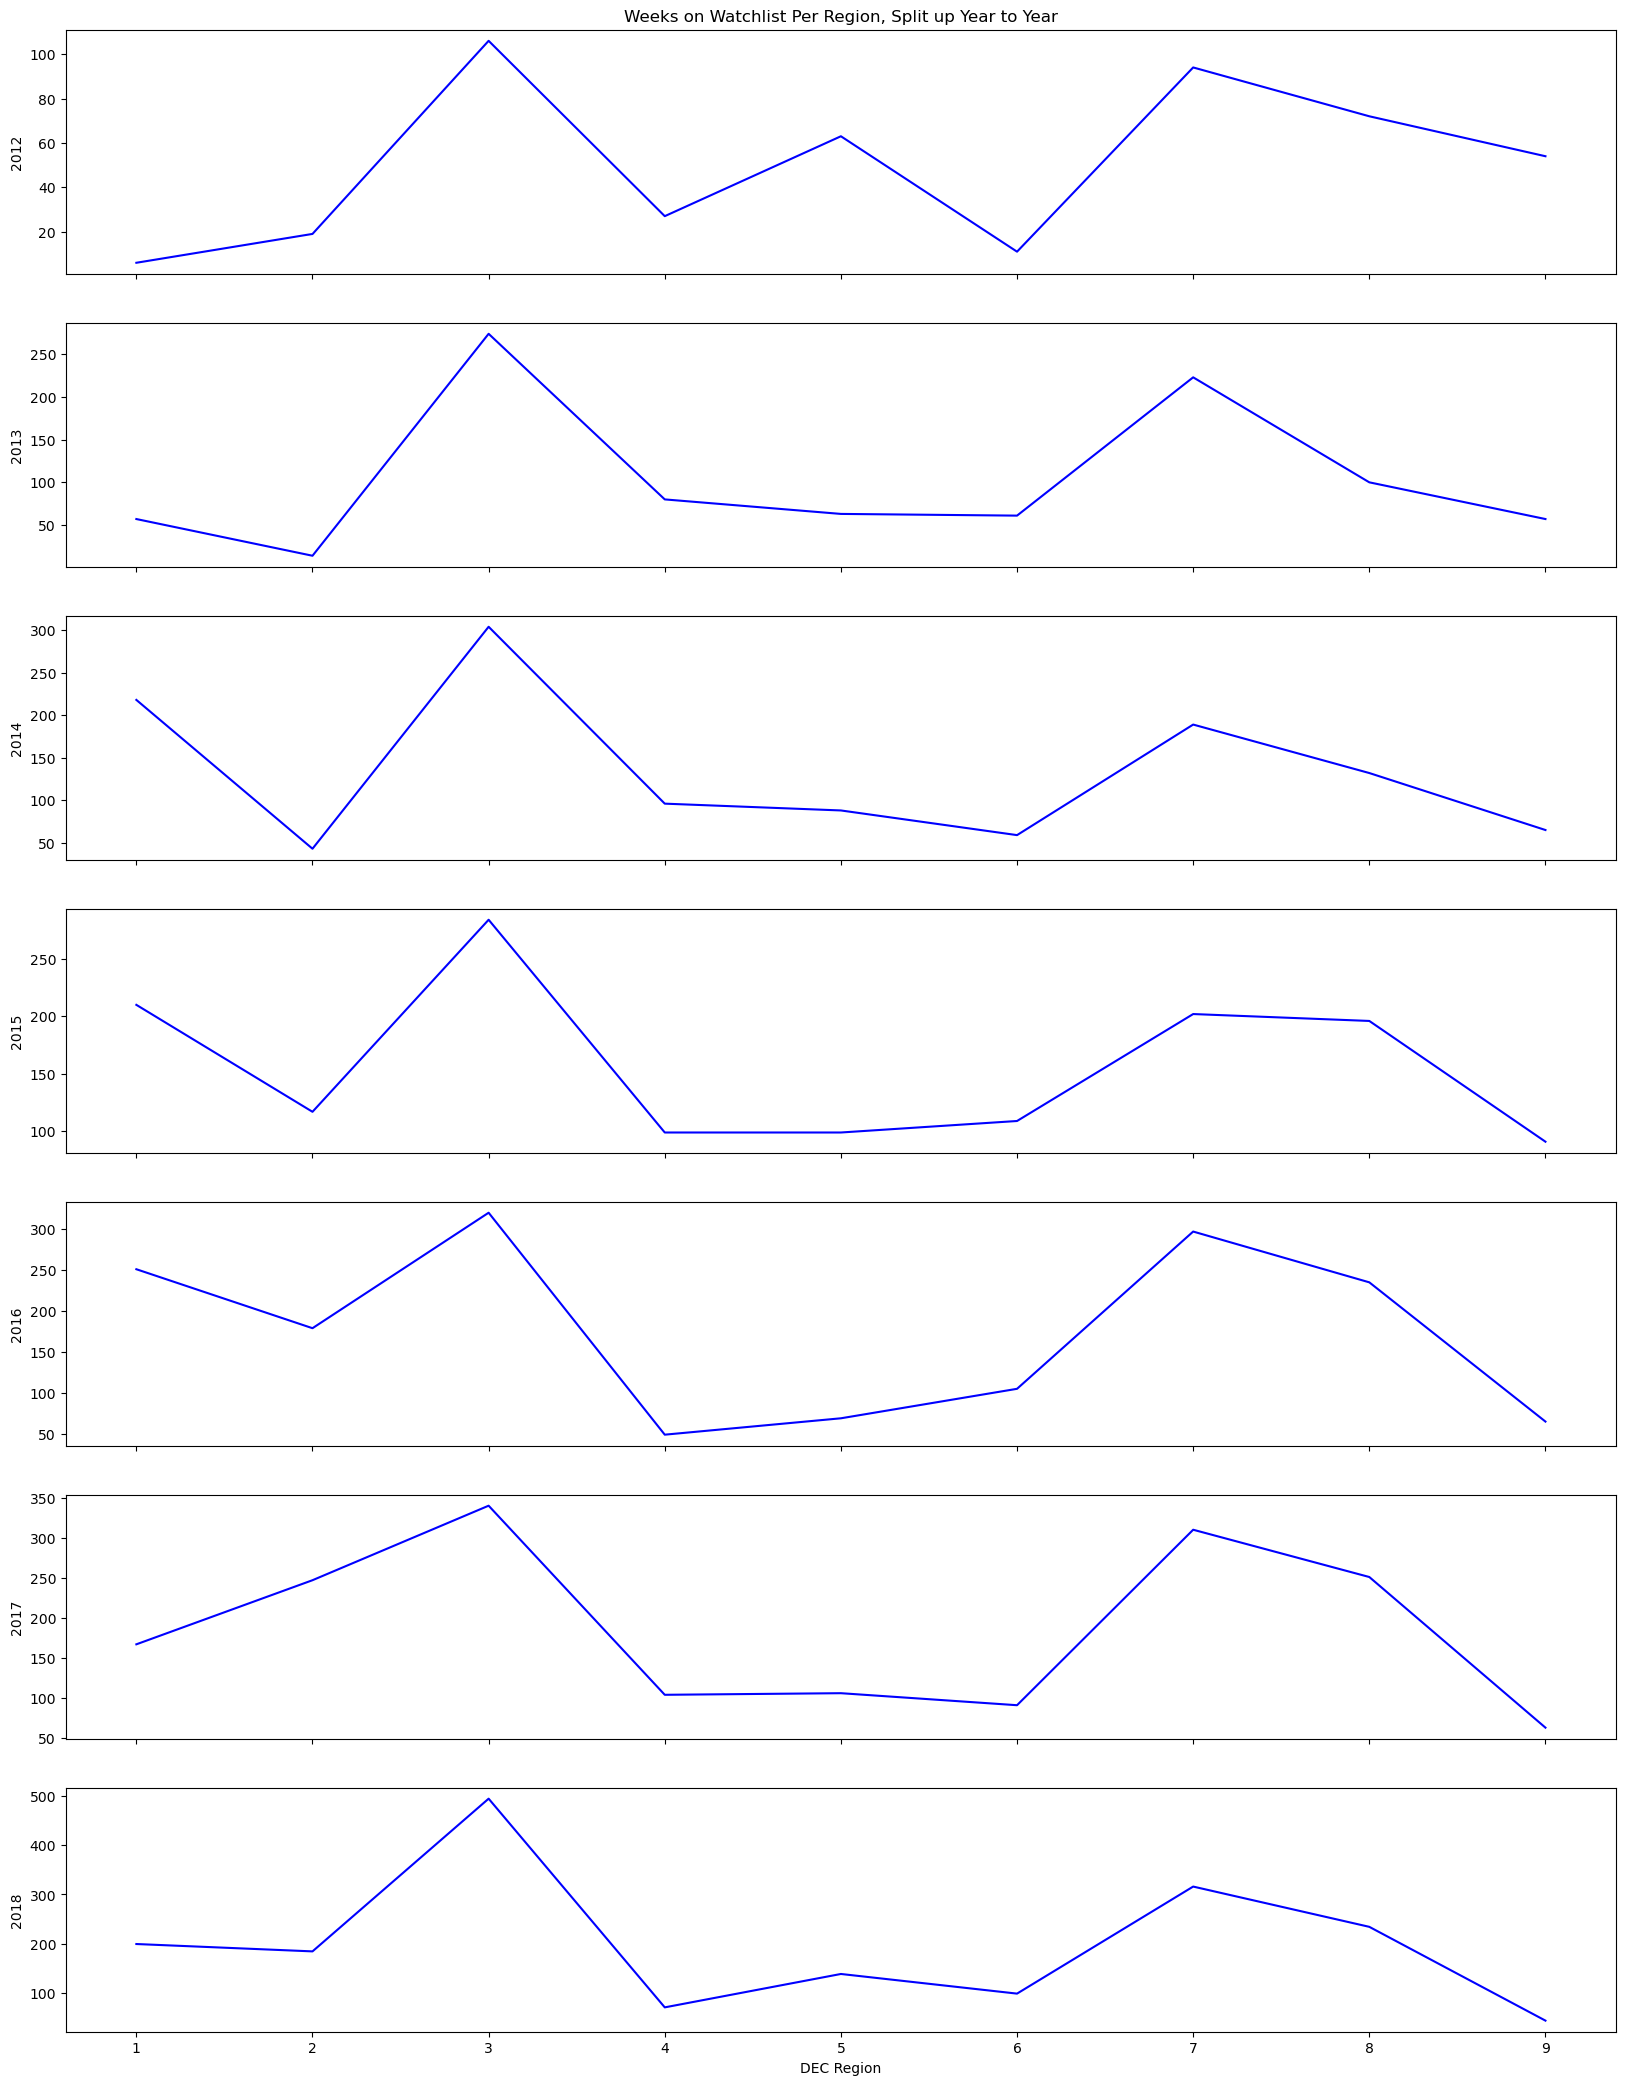

In [6]:
#%% Create multi-panel plot with each DEC region, per year

fig5, (ax15, ax25, ax35, ax45, ax55, ax65, ax75) = plt.subplots(7, 1,figsize = (20,26),sharex= True)

df2012 = yearly_dict[2012]

ax15.plot(df2012['DEC Region'],df2012['Number of Weeks on DEC Notification List'], 'b-', label = '2012')
ax15.set_ylabel('2012')

df2013 = yearly_dict[2013]

ax25.plot(df2013['DEC Region'],df2013['Number of Weeks on DEC Notification List'], 'b-', label = '2013')
ax25.set_ylabel('2013')

df2014 = yearly_dict[2014]

ax35.plot(df2014['DEC Region'],df2014['Number of Weeks on DEC Notification List'], 'b-', label = '2014')
ax35.set_ylabel('2014')

df2015 = yearly_dict[2015]

ax45.plot(df2015['DEC Region'],df2015['Number of Weeks on DEC Notification List'], 'b-', label = '2015')
ax45.set_ylabel('2015')

df2016 = yearly_dict[2016]

ax55.plot(df2016['DEC Region'],df2016['Number of Weeks on DEC Notification List'], 'b-', label = '2016')
ax55.set_ylabel('2016')

df2017 = yearly_dict[2017]

ax65.plot(df2017['DEC Region'],df2017['Number of Weeks on DEC Notification List'], 'b-', label = '2017')
ax65.set_ylabel('2017')

df2018 = yearly_dict[2018]

ax75.plot(df2018['DEC Region'],df2018['Number of Weeks on DEC Notification List'], 'b-', label = '2018')
ax75.set_ylabel('2018')
ax75.set_xlabel('DEC Region')
ax15.set_title('Weeks on Watchlist Per Region, Split up Year to Year')

From this graph, DEC Region 3 appears to consistently have the most HAB occurences year over year. In most other years, DEC Region 7 appears to have the second most occurences. Region 3 is in the southern region of the state, right above NYC. Looking at the map, the rivers flowing into this region have the greatest likelihood of containing HAB inducing nutrients, because the further downstream it travels, the  more chances for point and non-point pollution into the river. Some of these rivers then drain into lakes, transitioning from fast, potentially nutrient laden water into stagnant potentially nutrient laden water, ideal conditions for HAB formation.

#### Plot and examine distribution of HAB occurences
Develop a boxplot of HAB occurences, with weeks on DEC notification list on x-axis

Text(0.5, 1.0, 'Boxplot Distribution of HAB Occurences')

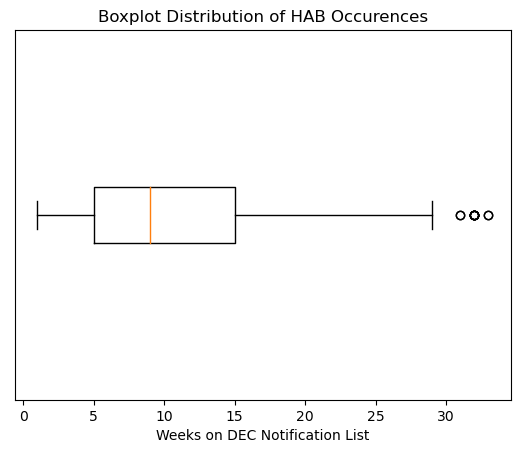

In [7]:
#%% Plot frequency distributions for total HAB occurences
# Set up boxplot 
fig6, ax16 = plt.subplots()
# Plot data from HAB dataframe
ax16.boxplot(dfhab['Number of Weeks on DEC Notification List'], vert = False)
# Remove y ticks
plt.yticks([])
# Set xlabel, set title
ax16.set_xlabel('Weeks on DEC Notification List')
ax16.set_title('Boxplot Distribution of HAB Occurences')



From the box plot, it appears that most of the HAB occurences in lakes are on the DEC watchlist for a little less than 10 weeks, with most of the occurences in the range of 5 to 15 weeks. The boxplot also identifies three outlier HAB occurences, all over 30 weeks. 

#### Calculate the cumulative number of weeks on DEC notification list per DEC Region, over time
Sum the number of weeks on DEC watchlist for different regions.

In [8]:
# Access dictionary to create dataframes for each region
dfdec1 = region_dict[1]

dfdec2 = region_dict[2]

dfdec3 = region_dict[3]

dfdec4 = region_dict[4]

dfdec5 = region_dict[5]

dfdec6 = region_dict[6]

dfdec7 = region_dict[7]

dfdec8 = region_dict[8]

dfdec9 = region_dict[9]


# Create list with names of the dataframes
dataframes = [dfdec1, dfdec2, dfdec3, dfdec4, dfdec5, dfdec6, dfdec7, dfdec8, dfdec9] 

# Create list of columns to be used in new dataframe
column_names = ['DEC1','DEC2','DEC3','DEC4','DEC5','DEC6','DEC7', 'DEC8', 'DEC9']

# create an empty dataframe to store cumulative sums
cumulative_df = pd.DataFrame()

# For loops that runs through regional dataframes, takes the cumulative sum of weeks on DEC watchlist, and adds it as a new columns in a new dataframe
for i, dataframe in enumerate(dataframes):
    dataframe = dataframe.drop(columns=['Year']) # drop the 'Year' column
    dataframe = dataframe.reset_index() # reset the index
    running = dataframe.groupby('Year')['Number of Weeks on DEC Notification List'].sum()
    cumulative_sum = dataframe['Number of Weeks on DEC Notification List'].cumsum()
    cumulative_df[column_names[i]] = cumulative_sum
   

Develop a plot of the cumulative totals each region spent on the DEC watchlist over the period where data is available. Because some columns were forward filled, plateaus on the plot represent stops in HAB data for that region. The slopes of the lines will give insight on the rate of HAB formation over the various regions.

    DEC1  DEC2  DEC3  DEC4  DEC5  DEC6  DEC7  DEC8  DEC9
0      6  19.0    14  11.0  12.0   6.0     5    12   8.0
1     19  28.0    18  27.0  26.0  11.0     6    17  15.0
2     27  33.0    27  31.0  29.0  27.0    13    24  22.0
3     41  50.0    35  38.0  48.0  43.0    32    29  30.0
4     49  56.0    45  50.0  49.0  52.0    43    38  31.0
..   ...   ...   ...   ...   ...   ...   ...   ...   ...
91  1061   NaN   982   NaN   NaN   NaN   981   928   NaN
92  1067   NaN   984   NaN   NaN   NaN   983   946   NaN
93  1086   NaN   993   NaN   NaN   NaN   988   950   NaN
94  1092   NaN  1009   NaN   NaN   NaN   993   969   NaN
95  1108   NaN  1018   NaN   NaN   NaN  1005   972   NaN

[96 rows x 9 columns]


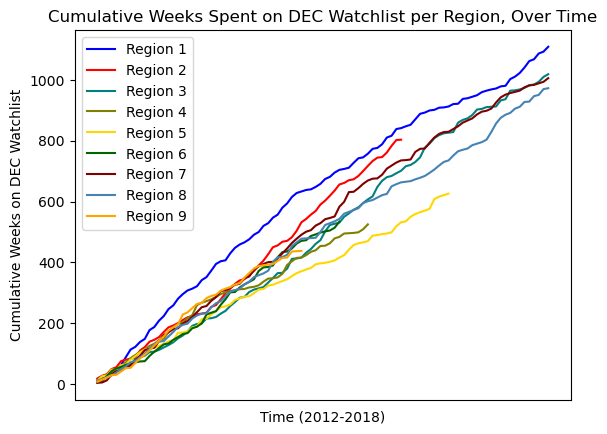

In [9]:
#%% Plot cumulative sums over time
# Set up plot
fig7, ax17 = plt.subplots()
# Plot region 1, continuing with the rest
ax17.plot(cumulative_df.index,cumulative_df['DEC1'], color = 'blue', label = 'Region 1')

ax17.plot(cumulative_df.index,cumulative_df['DEC2'], color = 'red', label = 'Region 2')

ax17.plot(cumulative_df.index,cumulative_df['DEC3'], color = '#008080', label = 'Region 3')

ax17.plot(cumulative_df.index,cumulative_df['DEC4'], color = 'olive', label = 'Region 4')

ax17.plot(cumulative_df.index,cumulative_df['DEC5'], color = 'gold', label = 'Region 5')

ax17.plot(cumulative_df.index,cumulative_df['DEC6'], color = 'darkgreen', label = 'Region 6')

ax17.plot(cumulative_df.index,cumulative_df['DEC7'], color = 'maroon', label = 'Region 7')

ax17.plot(cumulative_df.index,cumulative_df['DEC8'], color = 'steelblue', label = 'Region 8')

ax17.plot(cumulative_df.index,cumulative_df['DEC9'], color = 'orange', label = 'Region 9')

# Set up legend
ax17.legend()
# Add labels, title
ax17.set_ylabel('Cumulative Weeks on DEC Watchlist')
ax17.set_xlabel('Time (2012-2018)')
ax17.set_title('Cumulative Weeks Spent on DEC Watchlist per Region, Over Time')
# Remove x ticks
plt.xticks([])
print(cumulative_df)

Based on this graph, it appears that DEC Region 1 experienced HAB formation at the highest rate over the studied period. Although the multi-panel suggests that region 3 experienced the most HAB occurences per year, that figure was per year, while this plot is only cumulative and ranging from 2012-2018. Because some regions stop before others doesn't mean they stopped expereincing HAB formations, just that they didn't in total experience as much relative to other regions. Regions 3 and 7 were identified as having consistently high HAB occurences per year based on previous plots, and the cumulative plot appears to affirm this

## Discussion:
HABs can be toxic to humans, and at the minimum their occurence in drinking water sources can cause shutdowns and inconviences to the public, along with shutting down local recreational areas. Communities reliant on surface water are at an increased risk, as detection of toxic HABs in their water can force the switch to suplemental sources. Due to recent droughts, some of these areas may not have the capacity in their water systems to deal with issues associated with blooms. Aside from the negative impacts HABs can have on recreational activities, they can also impact industries. HABs can lead to reduced fish harvests, which in turn can drive food insecurity in regions especailly dependent on fish as a food and monetary source. It can also lead to a decrease in tourism revenue, as decreased recreational areas drive consumers to non-impacted destinations.

Based on the figures, it appears that DEC Regions 3 and 7 deal with the most HAB occurences per year, as well as having some of the highest total weeks spent on the watchlist for the studied period. Region 3 is in the southern region of the state, so a lot of the rivers flowing into it have had ample oppurtunity compared to other regions to be contaminated with HAB inducing nutrients, either from point sources such as regulated wastewater treatment discharges, or non-point sources such as fertilizer runoff and sewer system leaks. Region 7 is in the central part of the state, and based on this analysis and research it is not clear what could be driving the higher HAB occurences. Region 1 had the most total weeks spent on the DEC watchlist out of the regions. Similair to Region 3, Region 1 is located in the southern part of the state. They are seperated by Region 2 though, which did not appear to have the same rates of HAB occurences relative to these two. This could be due to a lack of slow moving water in this area. Region 2 primarily encompasses New York City, so the number of lakes and areas with slow moving water is likely low, especailly when compared to Region 3 which is relatively more rural, and Region 2 which encompasses Long Island, also relatively more rural with a higher likelihood for slow moving water condusive to HAB formation.

HABs throughout the state of NY were analyzed, but precip and discharge data was only looked at for a single site. These are intended to charecterize the ET and water movement, but there are issues with using it for the whole state. The HAB data only goes back to 2012, and the practices that led to the increase in HAB occurence likely started before that, so the complete picture on HAB data is not clear with just this analysis. It is also not abundtantly clear if the HAB data records all occurences of HAB formation in all lakes in NY, or rather within only certain lakes. If the latter is the case, this would skew the results toward regions with more surveyed lakes.
